## Autoregressive Model 


An autoregressive model is when a value from a time series is regressed on previous values from that same time series. for example, $y_t$ on $y_{t-1}$

$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

$y_{t-1}$ - previous value

$\beta_0$ - constant (bias)

$\beta_1$ - coeff 

$\epsilon_t$ - Residual (error term)

!! How many lags we need to keep !! - Depending on our task. More lags make models more complex.

Note: we use Auto-correlation, and Partial Autocorrelation to determine the number of lags.

#### Determining the number of Lags using ACF and PACF


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

##### Primary preprocessing 

In [2]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv") 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [3]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
# picking market value for FTSE 
df['market_value'] = df.ftse

df.drop(["spx","ftse", "nikkei","dax"], axis=1, inplace=True)
df.describe()

,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


#### Split the data

In [5]:
train_locs = int(df.shape[0]*0.8)
train_locs

5021

In [6]:
df_train, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df_train, df_test

(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

#### ACF

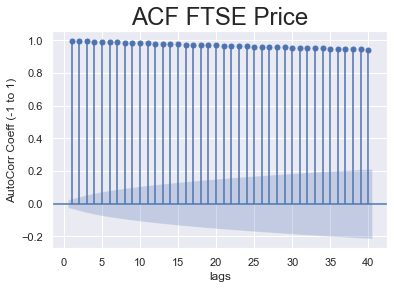

In [7]:
sgt.plot_acf(df.market_value, lags=40, zero=False) 
plt.title("ACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

#### PACF

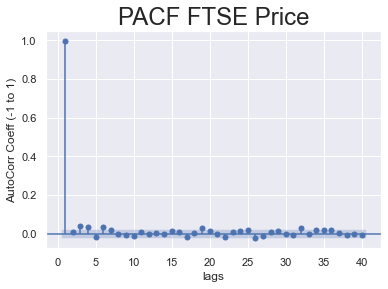

In [8]:
sgt.plot_pacf(df.market_value, lags=40, zero=False) 
plt.title("PACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

Looking at the both graph, we have coefficients that are not significant. The ACF all 40 lag values have ACF coefficient between 0.9 -1, but the PACF coefficients are different. There are some negatively correlated values too. In PACF graph, lags later than 20 are insignificant. Hence, we can conclude 20 lags for our AR model. 

#### AR (1) Model 

Autoregressive model with 1 lag.

In [9]:
ar_model = ARIMA(df.market_value, order=(1,1,1))

In [10]:
ar_results = ar_model.fit()

c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [11]:
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -34418.309
Date:                Thu, 18 Aug 2022   AIC                          68842.619
Time:                        11:25:36   BIC                          68862.852
Sample:                    01-07-1994   HQIC                         68849.630
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8292      0.042     19.904      0.000       0.748       0.911
ma.L1         -0.8641      0.037    -23.249      0.000      -0.937      -0.791
sigma2      3396.1057     36.186     93.850      0.000    3325.181    3467.030
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):              3731.72
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.32
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lets put the summary into AR equation
$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

looking at the ARIMA Model summary. 

$\beta_0$ = 5423.6789

$\beta_2$ = 0.9988 (Can match with ACF graph too)

$\epsilon_t$ = 0.001

$Z$ - z statistics 

$P>|z|$ - p-value, we have 0.00, and safe to conclude the $\beta_0$ and $\beta_1$ are significantly different than zero.

[0.025  0.975] - Gives us the 90% confidence interval. Since, zero is not part if it, hence we can conclude that the coefficients are significant. 

#### Going Higher with Lag values 

We are going to check AR(2) ... AR(N) models, and use Log-Likelihood ratio test to examine the models performance based on Lag values.

#### AR(2) Model

In [12]:
ar2_model = ARIMA(df.market_value, order=(2,1,1))
ar2_results = ar2_model.fit()
ar2_results.summary()

c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -34414.111
Date:                Thu, 18 Aug 2022   AIC                          68836.221
Time:                        11:25:38   BIC                          68863.199
Sample:                    01-07-1994   HQIC                         68845.569
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6765      0.064     10.557      0.000       0.551       0.802
ar.L2         -0.0456      0.010     -4.625      0.000      -0.065      -0.026
ma.L1         -0.6897      0.063    -10.986      0.000      -0.813      -0.567
sigma2      3395.8961     36.197     93.817      0.000    3324.951    3466.841
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3671.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.31
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to stats, $t-2$ has huge impact rather than $t-1$ lag. $t-1$ is insignificant, looking at $\rho$-value Lets, explore further.

In [13]:
ar3_model = ARIMA(df.market_value, order=(3,0,1))
ar3_results = ar3_model.fit()
ar3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -34422.142
Date:                Thu, 18 Aug 2022   AIC                          68856.284
Time:                        11:25:44   BIC                          68896.752
Sample:                    01-07-1994   HQIC                         68870.305
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6870    758.108      7.154      0.000    3937.823    6909.551
ar.L1          1.6689      0.067     24.992      0.000       1.538       1.800
ar.L2         -0.7149      0.063    -11.261      0.000      -0.839      -0.590
ar.L3          0.0458      0.010      4.652      0.000       0.026       0.065
ma.L1         -0.6822      0.066    -10.409      0.000      -0.811      -0.554
sigma2      3390.7853     36.396     93.165      0.000    3319.451    3462.119
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3653.42
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.30
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
ar7_model = ARIMA(df.market_value, order=(7,0,1))
ar7_results = ar7_model.fit()
ar7_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(7, 0, 1)   Log Likelihood              -34414.375
Date:                Thu, 18 Aug 2022   AIC                          68848.750
Time:                        11:25:47   BIC                          68916.197
Sample:                    01-07-1994   HQIC                         68872.119
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6798    540.461     10.035      0.000    4364.395    6482.965
ar.L1          0.6440      0.286      2.252      0.024       0.084       1.204
ar.L2          0.3019      0.283      1.067      0.286      -0.253       0.856
ar.L3         -0.0213      0.016     -1.360      0.174      -0.052       0.009
ar.L4          0.0628      0.010      6.018      0.000       0.042       0.083
ar.L5         -0.0245      0.021     -1.160      0.246      -0.066       0.017
ar.L6         -0.0037      0.015     -0.249      0.804      -0.033       0.025
ar.L7          0.0394      0.012      3.234      0.001       0.016       0.063
ma.L1          0.3435      0.287      1.199      0.231      -0.218       0.905
sigma2      3384.4529     37.079     91.276      0.000    3311.779    3457.127
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3441.74
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.29
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### LLR (Log-Likelihood) Test 

In [15]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p

Comparing the models

In [16]:
llr_test(ar_model, ar2_model)

c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.004

In [17]:
llr_test(ar2_model, ar3_model)

1.0

In [18]:
llr_test(ar_model, ar3_model)

1.0

Looking at the LLR test. we can say that higher the lag values, better is the prediction. We can continue until a point where p-values is > 0.5.

## Caution

We have assumed that the data is from stationary process, what if not !! Does AR works as expected !! Lets examine 

##### The DF-test 

In [19]:
sts.adfuller(df.market_value)

(-1.5977788921179843,
 0.48470912054659704,
 6,
 6270,
 {'1%': -3.4313933778649943,
  '5%': -2.862001080749219,
  '10%': -2.567015430304048},
 68476.87620974617)

We can see the ADF value, which tells us the data is not stationary. 

**What can we do about it ?**

To tackle this challenge, we will transform the data. We will use  **Return** - *The percentage change between two values for two consecutive periods.* 

$
Return = \frac{P_1 - P_{t-1}}{P_{t-1}} *100
$

We have pandas builtin function for it.


In [20]:
df['returns'] = df.market_value.pct_change(1).mul(100)

In [21]:
df.returns

date
1994-01-07         NaN
1994-01-10   -0.156704
1994-01-11   -0.779229
1994-01-12   -1.222988
1994-01-13   -0.356166
                ...   
2018-01-23    0.212382
2018-01-24   -1.143311
2018-01-25   -0.360951
2018-01-26    0.652605
2018-01-29    0.078168
Freq: B, Name: returns, Length: 6277, dtype: float64

We have one NaN value due to return compute. Because, first index value has no previous value to compare with. Hence we drop the instance, since it is just a single data example.

In [22]:
df = df[1:]
df.returns

date
1994-01-10   -0.156704
1994-01-11   -0.779229
1994-01-12   -1.222988
1994-01-13   -0.356166
1994-01-14    1.206842
                ...   
2018-01-23    0.212382
2018-01-24   -1.143311
2018-01-25   -0.360951
2018-01-26    0.652605
2018-01-29    0.078168
Freq: B, Name: returns, Length: 6276, dtype: float64

Lets just verify that we have returns data source is stationary.

In [23]:
sts.adfuller(df.returns)

(-15.140761332034796,
 7.016338451094158e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 19026.504469066465)

Looking at the ADF test scores, we can conclude that data is stationary looking at critical value, $\rho$-value, and lag.

#### Let Examine the ACF and PACF for Returns 

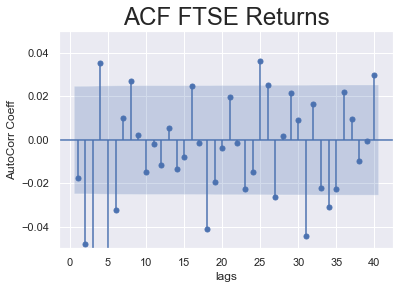

In [24]:
sgt.plot_acf(df.returns, lags=40, zero=False) 
plt.title("ACF FTSE Returns", size=24)
plt.ylabel("AutoCorr Coeff")
plt.ylim(-0.05, 0.05)
plt.xlabel("lags")
plt.show()

We see a different result than FTSE price. The magnitude is changed, and half of the points have negative correlation.

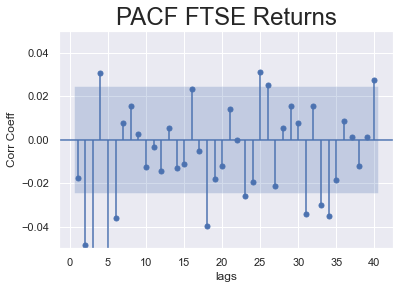

In [25]:
sgt.plot_pacf(df.returns, lags=40, zero=False, method=('ols')) 
plt.title("PACF FTSE Returns", size=24)
plt.ylabel("Corr Coeff")
plt.ylim(-0.05, 0.05)
plt.xlabel("lags")
plt.show()

Similarly, we have same results from PACF graph. Combining both (ACF, and PACF) graph, 5 of the first 6 coefficients are significant, and 4 of them are negative, which suggests the market is trying to adjust. For instance, If the price was decreased previously, then it will be increased today. *if you have notice during the AR(1), and AR(2) model build, we have the same effect present*. It is a cyclical change. As we move further back the less coefficient value will be.

## AR(1) !! Again

In [26]:
ar_ret_model = ARIMA(df.returns, order=(1,1,1))
ar_ret_result = ar_ret_model.fit()

In [27]:
ar_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9601.071
Date:                Thu, 18 Aug 2022   AIC                          19208.142
Time:                        11:26:08   BIC                          19228.375
Sample:                    01-10-1994   HQIC                         19215.153
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0174      0.008     -2.305      0.021      -0.032      -0.003
ma.L1         -1.0000      0.005   -194.136      0.000      -1.010      -0.990
sigma2         1.2471      0.013     97.574      0.000       1.222       1.272
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10519.92
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
ar_ret_model_2 = ARIMA(df.returns, order=(2,1,1))
ar_ret_result_2 = ar_ret_model_2.fit()
ar_ret_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9593.718
Date:                Thu, 18 Aug 2022   AIC                          19195.437
Time:                        11:26:12   BIC                          19222.414
Sample:                    01-10-1994   HQIC                         19204.784
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0183      0.008     -2.393      0.017      -0.033      -0.003
ar.L2         -0.0484      0.007     -6.933      0.000      -0.062      -0.035
ma.L1         -1.0000      0.019    -52.987      0.000      -1.037      -0.963
sigma2         1.2442      0.026     48.146      0.000       1.194       1.295
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             10345.58
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
ar_ret_model_3 = ARIMA(df.returns, order=(3,1,1))
ar_ret_result_3 = ar_ret_model_3.fit()
ar_ret_result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -9579.428
Date:                Thu, 18 Aug 2022   AIC                          19168.855
Time:                        11:26:17   BIC                          19202.577
Sample:                    01-10-1994   HQIC                         19180.539
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0216      0.008     -2.768      0.006      -0.037      -0.006
ar.L2         -0.0497      0.007     -7.163      0.000      -0.063      -0.036
ar.L3         -0.0674      0.007     -9.324      0.000      -0.082      -0.053
ma.L1         -1.0000      0.025    -39.398      0.000      -1.050      -0.950
sigma2         1.2385      0.032     38.364      0.000       1.175       1.302
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9361.96
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
ar_ret_model_4 = ARIMA(df.returns, order=(4,1,1))
ar_ret_result_4 = ar_ret_model_4.fit()
ar_ret_result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -9576.462
Date:                Thu, 18 Aug 2022   AIC                          19164.925
Time:                        11:26:22   BIC                          19205.391
Sample:                    01-10-1994   HQIC                         19178.946
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0196      0.008     -2.503      0.012      -0.035      -0.004
ar.L2         -0.0481      0.007     -6.898      0.000      -0.062      -0.034
ar.L3         -0.0667      0.007     -9.190      0.000      -0.081      -0.052
ar.L4          0.0308      0.007      4.245      0.000       0.017       0.045
ma.L1         -1.0000      0.013    -75.921      0.000      -1.026      -0.974
sigma2         1.2373      0.019     64.406      0.000       1.200       1.275
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9090.90
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
llr_test(ar_ret_model, ar_ret_model_2)

0.0

In [32]:
llr_test(ar_ret_model_2, ar_ret_model_3)

0.0

Here, Looking at the Log-likelihood, information criteria like AIC, BIC, and HQIC. It is better to have more lag values. But lets do one more test.

In [33]:
ar_ret_model_6 = ARIMA(df.returns, order=(6,1,1))
ar_ret_result_6 = ar_ret_model_6.fit()
ar_ret_result_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -9562.004
Date:                Thu, 18 Aug 2022   AIC                          19140.008
Time:                        11:26:45   BIC                          19193.962
Sample:                    01-10-1994   HQIC                         19158.702
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0198      0.008     -2.426      0.015      -0.036      -0.004
ar.L2         -0.0509      0.007     -7.155      0.000      -0.065      -0.037
ar.L3         -0.0721      0.007     -9.950      0.000      -0.086      -0.058
ar.L4          0.0278      0.007      3.800      0.000       0.013       0.042
ar.L5         -0.0582      0.007     -8.128      0.000      -0.072      -0.044
ar.L6         -0.0359      0.008     -4.550      0.000      -0.051      -0.020
ma.L1         -1.0000      0.019    -52.208      0.000      -1.038      -0.962
sigma2         1.2316      0.025     49.127      0.000       1.182       1.281
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8883.69
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
ar_ret_model_7 = ARIMA(df.returns, order=(7,1,1))
ar_ret_result_7 = ar_ret_model_7.fit()
ar_ret_result_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -9561.812
Date:                Thu, 18 Aug 2022   AIC                          19141.625
Time:                        11:26:56   BIC                          19202.324
Sample:                    01-10-1994   HQIC                         19162.656
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0195      0.008     -2.392      0.017      -0.036      -0.004
ar.L2         -0.0504      0.007     -7.034      0.000      -0.064      -0.036
ar.L3         -0.0722      0.007     -9.878      0.000      -0.087      -0.058
ar.L4          0.0283      0.007      3.827      0.000       0.014       0.043
ar.L5         -0.0578      0.007     -8.028      0.000      -0.072      -0.044
ar.L6         -0.0357      0.008     -4.518      0.000      -0.051      -0.020
ar.L7          0.0078      0.008      0.977      0.328      -0.008       0.023
ma.L1         -1.0000      0.022    -44.622      0.000      -1.044      -0.956
sigma2         1.2315      0.029     42.630      0.000       1.175       1.288
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8851.52
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
llr_test(ar_ret_model_6, ar_ret_model_7)

0.536

Looking at the LLR (log-Likelihood ratio test), we can say the best leg value is 6 for this model.

## Normalization

In Machine Learning, Normalzing is rescaling of data from the original range so that all vlaues are witin the range of 0 to 1. Here in times-eries, we map every value of smaple space to the precentage of the first value of set.


In [36]:
benchmark = df.market_value.iloc[0]

In [37]:
df['norm'] = df.market_value.div(benchmark).mul(100)
df.norm[:5]

date
1994-01-10    100.000000
1994-01-11     99.220771
1994-01-12     98.007313
1994-01-13     97.658244
1994-01-14     98.836824
Freq: B, Name: norm, dtype: float64

Hence, AR models work best with Stationary data. Lets exmine that

In [38]:
sts.adfuller(df.norm)

(-1.5870996932040797,
 0.4900704664018066,
 6,
 6269,
 {'1%': -3.4313935443677157,
  '5%': -2.8620011543157835,
  '10%': -2.5670154694652805},
 24302.76353860927)

Looking at the AD fuller test reuslt. The normalized data is not stationary, hence AR model is not apprrpriate.

**Lets normalize the returns** 

Suppose historically, the S&P provides significantly higher returns, the Nikkei, for instance, Nikkei yields a steady two percent increase over a given period, while the S&P returns an average three percent in the same time span. Then it returns for both are around the three percent mark for the period we are observing, Nikkei is significantly outperforming its expectations. So to avoid any biased comparison when analyzing the two sets, we often rely on normalized returns. They account for the absolute profitability of the investment in contrast to prices. Plus, they allow us to compare the relative profitability as opposed to non normalized returns. Overall, they are much more reliable measurements than the other two.

In [39]:
return_benchmark = df.returns.iloc[0]
df['returns_norm'] = df.returns.div(return_benchmark).mul(100)

In [40]:
df.iloc[:5]

,market_value,returns,norm,returns_norm
date,,,,
1994-01-10,3440.58,-0.156704,100.000000,100.000000
1994-01-11,3413.77,-0.779229,99.220771,497.260711
1994-01-12,3372.02,-1.222988,98.007313,780.443046
1994-01-13,3360.01,-0.356166,97.658244,227.285567
1994-01-14,3400.56,1.206842,98.836824,-770.139292


In [41]:
sts.adfuller(df.returns_norm)

(-15.140761332034806,
 7.016338451094053e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 99642.30855107102)

Now, we have stationary data, and can conclude that normalizing the data does not effect the  stationarity of the data.

**Fitting the normalized returns to AR Models**

In [42]:
ret_norm_model = ARIMA(df.returns_norm, order=(1, 1, 1))
ret_nomr_result = ret_norm_model.fit()
ret_nomr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_norm   No. Observations:                 6276
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -50128.407
Date:                Thu, 18 Aug 2022   AIC                         100262.813
Time:                        11:27:18   BIC                         100283.046
Sample:                    01-10-1994   HQIC                        100269.823
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0175      0.008     -2.310      0.021      -0.032      -0.003
ma.L1         -1.0000      0.077    -13.017      0.000      -1.151      -0.849
sigma2      5.081e+05   3.93e+04     12.920      0.000    4.31e+05    5.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10519.27
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
ret_norm_model_2 = ARIMA(df.returns_norm, order=(2, 1, 1))
ret_nomr_result_2 = ret_norm_model_2.fit()
ret_nomr_result_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_norm   No. Observations:                 6276
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -50121.060
Date:                Thu, 18 Aug 2022   AIC                         100250.119
Time:                        11:27:20   BIC                         100277.096
Sample:                    01-10-1994   HQIC                        100259.466
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0183      0.008     -2.398      0.016      -0.033      -0.003
ar.L2         -0.0484      0.007     -6.933      0.000      -0.062      -0.035
ma.L1         -1.0000      0.021    -47.949      0.000      -1.041      -0.959
sigma2      5.067e+05   1.14e+04     44.286      0.000    4.84e+05    5.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             10345.09
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
ret_norm_model_6 = ARIMA(df.returns_norm, order=(6, 1, 1))
ret_nomr_result_6 = ret_norm_model_6.fit()
ret_nomr_result_6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_norm   No. Observations:                 6276
Model:                 ARIMA(6, 1, 1)   Log Likelihood              -50089.343
Date:                Thu, 18 Aug 2022   AIC                         100194.686
Time:                        11:27:27   BIC                         100248.641
Sample:                    01-10-1994   HQIC                        100213.381
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0199      0.008     -2.487      0.013      -0.035      -0.004
ar.L2         -0.0509      0.007     -7.224      0.000      -0.065      -0.037
ar.L3         -0.0720      0.007    -10.422      0.000      -0.086      -0.058
ar.L4          0.0277      0.007      3.823      0.000       0.014       0.042
ar.L5         -0.0582      0.007     -8.275      0.000      -0.072      -0.044
ar.L6         -0.0359      0.008     -4.608      0.000      -0.051      -0.021
ma.L1         -1.0000      0.009   -105.991      0.000      -1.018      -0.982
sigma2      5.016e+05   1.88e-08   2.67e+13      0.000    5.02e+05    5.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8883.80
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+27. Standard errors may be unstable.
"""

In [45]:
ret_norm_model_7 = ARIMA(df.returns_norm, order=(7, 1, 1))
ret_nomr_result_7 = ret_norm_model_7.fit()
ret_nomr_result_7.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_norm   No. Observations:                 6276
Model:                 ARIMA(7, 1, 1)   Log Likelihood              -50089.152
Date:                Thu, 18 Aug 2022   AIC                         100196.304
Time:                        11:27:38   BIC                         100257.003
Sample:                    01-10-1994   HQIC                        100217.335
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0196      0.008     -2.443      0.015      -0.035      -0.004
ar.L2         -0.0504      0.007     -7.116      0.000      -0.064      -0.037
ar.L3         -0.0722      0.007    -10.275      0.000      -0.086      -0.058
ar.L4          0.0283      0.007      3.864      0.000       0.014       0.043
ar.L5         -0.0578      0.007     -8.193      0.000      -0.072      -0.044
ar.L6         -0.0357      0.008     -4.573      0.000      -0.051      -0.020
ar.L7          0.0078      0.008      0.987      0.324      -0.008       0.023
ma.L1         -1.0000      0.010   -105.178      0.000      -1.019      -0.981
sigma2      5.015e+05    1.9e-08   2.65e+13      0.000    5.02e+05    5.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8851.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.94e+27. Standard errors may be unstable.
"""

The results from normalized returns and non-normalized returns are simialr. This means using normalized values have no impact on model selection.

### Residuals $\epsilon$

In [46]:
# model result are taken from previous price data model
df['res_price'] = ar7_results.resid

In [47]:
df['res_price']


date
1994-01-10    -7.835295
1994-01-11   -29.277332
1994-01-12   -44.584900
1994-01-13   -16.322248
1994-01-14    34.765395
                ...    
2018-01-23    18.067363
2018-01-24   -86.029241
2018-01-25   -28.279986
2018-01-26    49.193841
2018-01-29     2.688059
Freq: B, Name: res_price, Length: 6276, dtype: float64

In [48]:
df.res_price.mean()

0.7850213811150677

In [49]:
df.res_price.var()

3381.5113911200733

The mean is close to zero, which suggests that on average, our model performs well, but the high variance indicates the residuals are not concentrated around the mean of zero, but are all over the place.This is primarily because our models perform poorly when predicting non stationary data.
Now, we still need to run the Dickie Fuller test to see if the Time series is stationary, we call the A.D. Fuller method from the START package and use the newly generated time series as an argument. 

In [50]:
sts.adfuller(df.res_price)

(-79.23348443526143,
 0.0,
 0,
 6275,
 {'1%': -3.431392546147741,
  '5%': -2.8620007132681926,
  '10%': -2.567015234685164},
 68455.05219028583)

Here, $\rho$-value is zero, and critical values are greateer than test result. It is a stationary data. 

Lets plot hte ACF graph.

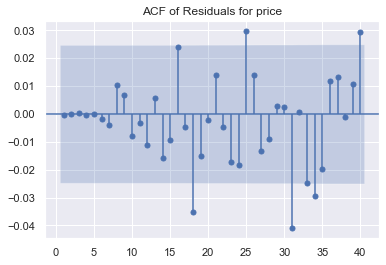

In [51]:
sgt.plot_acf(df.res_price, zero=False, lags=40)
plt.title("ACF of Residuals for price")
plt.show()

After plotting the function, we can see that the majority of coefficients fall within the blue region, as you know, this suggests they're not significantly different from zero, which fits the characteristics of white noise. However, the few points that fall outside this area lead us to believe that there's an even better predictor. we must plot the values of the residuals to see if they resemble what we are used to expecting from white noise data.

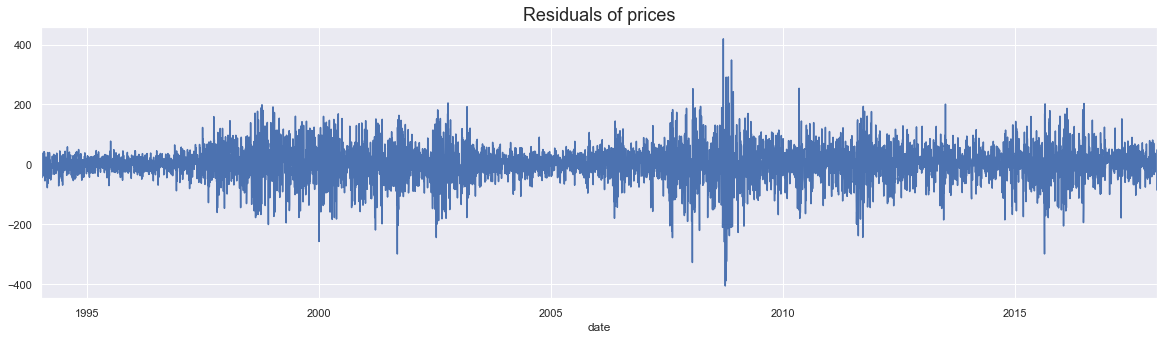

In [55]:
df.res_price.plot(figsize=(20,5))
plt.title('Residuals of prices', size=18)
plt.show()

We can not find any obvious pattern for the data, so our choice of model is correct. It's important to note that since we used an AR model on non stationary data, our predictions might
still be far from great. Lets examine for residuals of resturns by following the actions.

**Analysing the return residuals**

In [56]:
df['res_return'] = ar_ret_result_6.resid

In [57]:
df.res_return.mean()

0.0018341257844579632

In [58]:
df.res_return.var()

1.2327574191816837

We find the mean and variance once again,and their values are closer to what we might expect from white noise data.I mean, extremely close to zero and a variance of around one indicate that our choice of model was pretty good. 

In [59]:
sts.adfuller(df.res_return)

(-14.96310869997821,
 1.231206630866934e-27,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 19033.083460797836)

Running the Deqi Fuller test returns values close to those of the price residuals, so we have confirmation that the data is stationary. Since white noise is stationary, this is exactly what we wanted. Lets examine the ACF too.

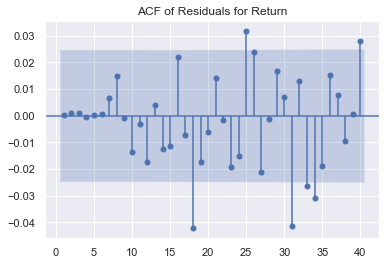

In [60]:
sgt.plot_acf(df.res_return, zero=False, lags=40)
plt.title("ACF of Residuals for Return")
plt.show()

we can observe a very similar scenario where most but not all coefficients are not significant. Hence our model is a good predictor, but we have a good reason to believe a better one exists. Fnally, we plot the data.

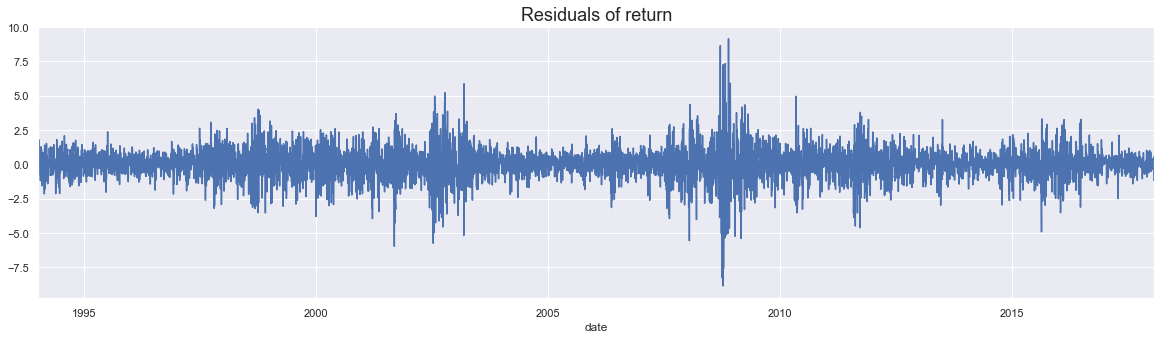

In [61]:
df.res_return.plot(figsize=(20,5))
plt.title('Residuals of return', size=18)
plt.show()

As was the case with prices, our residuals are mostly low except for around the end of 2008. This, of course, coincides with the start of the Great Recession, which few people could have anticipated.